In [41]:
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [42]:
TICKER = "AAPL"
PERIOD = "2y"
TARGET = "Adj Close"
SAVE_DIR = Path("optuna_results")
SAVE_DIR.mkdir(exist_ok=True)

df = yf.download(TICKER, period=PERIOD, interval="1d", auto_adjust=False)
df.reset_index(inplace=True)
df.rename(columns={
    "Date": "Date",
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Close": "Close",
    "Adj Close": "Adj Close",
    "Volume": "Volume"
}, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [43]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df['Adj Close'] = df['Adj Close'].dropna()
df = df.ffill().bfill()

In [44]:
def features_engineering(data: pd.DataFrame) -> pd.DataFrame:
    d = data.copy()
    for w in [5, 10, 20]:
        d[f"ret_{w}"] = d[TARGET].pct_change(w)
        d[f"ma_{w}"] = d[TARGET].rolling(w).mean()
        d[f"vol_{w}"] = d[TARGET].pct_change().rolling(w).std()
    d["hl_spread"] = (d["High"] - d["Low"]) / d[TARGET]
    d["oc_spread"] = (d["Close"] - d["Open"]) / d[TARGET]
    d["Volume_chg"] = d["Volume"].pct_change()

    lag_cols = [c for c in d.columns if c not in ["Date", TARGET]]
    for c in lag_cols:
        d[c] = d[c].shift(1)

    d["y_next"] = d[TARGET].shift(-1)
    return d.dropna().reset_index(drop=True)

In [62]:
df_feat = add_features(df)
FEATURES = [c for c in df_feat.columns if c not in ["Date", TARGET, "y_next"]]
X = df_feat[FEATURES].values
y = df_feat["y_next"].values
dates = df_feat["Date"].values

In [66]:
tmp = df_feat.drop(columns=["Date", "y_next"], errors="ignore")
num_df = tmp.select_dtypes(include=[np.number]).copy()
num_df = num_df.replace([np.inf, -np.inf], np.nan)

y_series = df_feat["y_next"]
dates_series = df_feat["Date"]

valid_idx = num_df.dropna().index
X_df = num_df.loc[valid_idx]
y = y_series.loc[valid_idx].values
dates = dates_series.loc[valid_idx].values

const_cols = X_df.columns[X_df.nunique() <= 1]
if len(const_cols) > 0:
    X_df = X_df.drop(columns=const_cols)

X = X_df.values

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

In [67]:
def objective(trial):
    model_type = trial.suggest_categorical("model_type", ["ridge", "rf"])

    if model_type == "ridge":
        alpha = trial.suggest_loguniform("alpha", 1e-3, 1e2)
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=alpha, random_state=42))
        ])
    else:
        n_estimators = trial.suggest_int("n_estimators", 100, 600)
        max_depth = trial.suggest_int("max_depth", 4, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred) ** 0.5
        rmse_scores.append(rmse)
    return np.mean(rmse_scores)

In [68]:
print("🔍 Running Optuna optimization...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, timeout=600)

print("\n🏆 Best trial:")
print(f"  Value (RMSE): {study.best_value:.4f}")
print(f"  Params: {study.best_params}")

[I 2025-11-06 22:59:08,910] A new study created in memory with name: no-name-b2d69ba8-ecf6-404d-926b-b5d776e72f00
[I 2025-11-06 22:59:08,921] Trial 0 finished with value: 4.312891281562254 and parameters: {'model_type': 'ridge', 'alpha': 0.0031608821634943668}. Best is trial 0 with value: 4.312891281562254.


🔍 Running Optuna optimization...


[I 2025-11-06 22:59:09,335] Trial 1 finished with value: 9.706366643138375 and parameters: {'model_type': 'rf', 'n_estimators': 170, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 4.312891281562254.
[I 2025-11-06 22:59:09,930] Trial 2 finished with value: 9.675223837065754 and parameters: {'model_type': 'rf', 'n_estimators': 277, 'max_depth': 18, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 4.312891281562254.
[I 2025-11-06 22:59:09,934] Trial 3 finished with value: 4.288939692504256 and parameters: {'model_type': 'ridge', 'alpha': 1.4668488876381038}. Best is trial 3 with value: 4.288939692504256.
[I 2025-11-06 22:59:10,610] Trial 4 finished with value: 9.73394346191444 and parameters: {'model_type': 'rf', 'n_estimators': 345, 'max_depth': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 3 with value: 4.288939692504256.
[I 2025-11-06 22:59:10,614] Trial 5 finished with value: 4.288856378230532 and par


🏆 Best trial:
  Value (RMSE): 4.2091
  Params: {'model_type': 'ridge', 'alpha': 0.019293180417396416}


In [69]:
best_params = study.best_params
if best_params["model_type"] == "ridge":
    model_final = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=best_params["alpha"], random_state=42))
    ])
else:
    model_final = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=42,
        n_jobs=-1
    )

model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)

In [70]:
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
print(f"\n📊 Test RMSE: {rmse:.4f}")
print(f"📊 R² Score: {r2:.4f}")



📊 Test RMSE: 3.6207
📊 R² Score: 0.9713


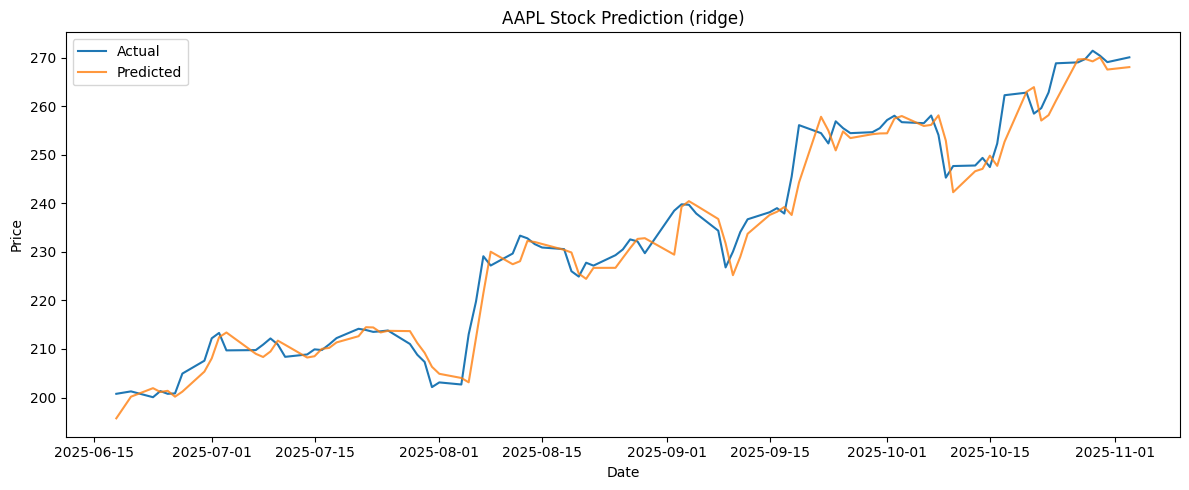

🖼️ Plot saved to optuna_results/AAPL_optuna_pred.png


In [71]:
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test, label="Actual", linewidth=1.5)
plt.plot(dates_test, y_pred, label="Predicted", alpha=0.8)
plt.title(f"{TICKER} Stock Prediction ({best_params['model_type']})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR / f"{TICKER}_optuna_pred.png", dpi=150)
plt.show()

print(f"🖼️ Plot saved to {SAVE_DIR / f'{TICKER}_optuna_pred.png'}")
